In [2]:
# Install Necessary Libraries

! pip install -q datasets
! pip install -q pytesseract
! pip install -q pyyaml==5.1
! sudo apt install tesseract-ocr
! pip install -q git+https://github.com/huggingface/transformers.git
! python -m pip install -q 'git+https://github.com/facebookresearch/detectron2.git'
! pip install -q torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html


## Restart runtime

     |████████████████████████████████| 346 kB 9.1 MB/s 
     |████████████████████████████████| 212 kB 53.4 MB/s 
     |████████████████████████████████| 86 kB 7.0 MB/s 
     |████████████████████████████████| 140 kB 58.3 MB/s 
     |████████████████████████████████| 86 kB 6.1 MB/s 
     |████████████████████████████████| 1.1 MB 55.4 MB/s 
     |████████████████████████████████| 596 kB 51.3 MB/s 
     |████████████████████████████████| 127 kB 43.5 MB/s 
     |████████████████████████████████| 144 kB 65.7 MB/s 
     |████████████████████████████████| 271 kB 68.1 MB/s 
     |████████████████████████████████| 94 kB 4.2 MB/s 
     |████████████████████████████████| 112 kB 26.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 3.1 

In [1]:
import PIL
import time
import zipfile
import pathlib
import pytesseract
import pandas as pd
import tensorflow as tf
from datasets import Dataset 
import requests, zipfile, io
from tensorflow import keras
from transformers import AdamW
from tqdm.notebook import tqdm
from tensorflow.keras import layers
from PIL import Image, ImageDraw, ImageFont
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.layers import Dense, Flatten
from transformers import LayoutLMv2ForSequenceClassification
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D
from transformers import LayoutLMv2FeatureExtractor, LayoutLMv2Tokenizer, LayoutLMv2Processor

# Exercise

#### Ants & Bees Classification

In [2]:
! curl https://download.pytorch.org/tutorial/hymenoptera_data.zip -o hymenoptera_data.zip
! unzip hymenoptera_data.zip

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45.0M  100 45.0M    0     0  35.9M      0  0:00:01  0:00:01 --:--:-- 35.9M
Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hym

## Pytorch

In [3]:
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import torch
import os

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = 'hymenoptera_data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [4]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f0fff1d3a90>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f0fff1d2950>}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


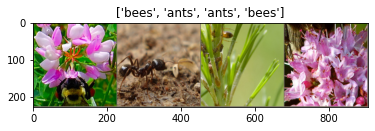

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Requirements

Using Resnet18, train model for 20 epochs -

* Without pretrained weights
* With pretrained weights, freezing extractor part.
* With pretrained weights, unfreeze some extra layers in extractor
* With pretrained weights, unfreeze all extractor layers

Show model performance by plotting validation loss and accuracy. 

Discuss difference in results. 



Clue - 
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [6]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import copy

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=21):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Using Resnet18, train model for 20 epochs - Without pretrained weights

In [9]:
model_ft = models.resnet18(pretrained=None)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=21)

Epoch 0/20
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.8959 Acc: 0.5369
val Loss: 0.9015 Acc: 0.5425

Epoch 1/20
----------
train Loss: 0.7496 Acc: 0.6230
val Loss: 0.8205 Acc: 0.6209

Epoch 2/20
----------
train Loss: 0.9872 Acc: 0.5328
val Loss: 0.7496 Acc: 0.6863

Epoch 3/20
----------
train Loss: 0.8184 Acc: 0.5492
val Loss: 0.8383 Acc: 0.6144

Epoch 4/20
----------
train Loss: 0.6696 Acc: 0.5984
val Loss: 0.6848 Acc: 0.5817

Epoch 5/20
----------
train Loss: 0.7848 Acc: 0.5943
val Loss: 0.9971 Acc: 0.6863

Epoch 6/20
----------
train Loss: 0.7866 Acc: 0.5738
val Loss: 0.6165 Acc: 0.6797

Epoch 7/20
----------
train Loss: 0.6621 Acc: 0.6270
val Loss: 0.5933 Acc: 0.6667

Epoch 8/20
----------
train Loss: 0.6171 Acc: 0.6475
val Loss: 0.6162 Acc: 0.6601

Epoch 9/20
----------
train Loss: 0.5865 Acc: 0.6639
val Loss: 0.6059 Acc: 0.6471

Epoch 10/20
----------
train Loss: 0.6392 Acc: 0.6230
val Loss: 0.6438 Acc: 0.6536

Epoch 11/20
----------
train Loss: 0.6016 Acc: 0.6762
val Loss: 0.6483 Acc: 0.6601

Epoch 12/20
----------
t

### Using Resnet18, train model for 20 epochs - With pretrained weights, freezing extractor part
loading pretrained weights imagenet with freezing extractor part

In [13]:
model_conv = torchvision.models.resnet18(pretrained='imagenet')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [14]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=21)

Epoch 0/20
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.8005 Acc: 0.5984
val Loss: 0.2370 Acc: 0.9216

Epoch 1/20
----------
train Loss: 0.7922 Acc: 0.6844
val Loss: 0.6620 Acc: 0.7320

Epoch 2/20
----------
train Loss: 0.5940 Acc: 0.7623
val Loss: 0.1870 Acc: 0.9346

Epoch 3/20
----------
train Loss: 0.7849 Acc: 0.7418
val Loss: 0.2300 Acc: 0.9281

Epoch 4/20
----------
train Loss: 0.4633 Acc: 0.8156
val Loss: 0.3437 Acc: 0.8889

Epoch 5/20
----------
train Loss: 0.6213 Acc: 0.7500
val Loss: 0.2248 Acc: 0.9346

Epoch 6/20
----------
train Loss: 0.4141 Acc: 0.8443
val Loss: 0.1994 Acc: 0.9608

Epoch 7/20
----------
train Loss: 0.4107 Acc: 0.8279
val Loss: 0.1945 Acc: 0.9542

Epoch 8/20
----------
train Loss: 0.3601 Acc: 0.8361
val Loss: 0.2114 Acc: 0.9412

Epoch 9/20
----------
train Loss: 0.3081 Acc: 0.8689
val Loss: 0.2148 Acc: 0.9477

Epoch 10/20
----------
train Loss: 0.5412 Acc: 0.7746
val Loss: 0.1989 Acc: 0.9542

Epoch 11/20
----------
train Loss: 0.3893 Acc: 0.8361
val Loss: 0.2194 Acc: 0.9477

Epoch 12/20
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


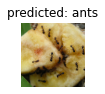

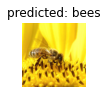

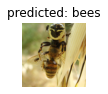

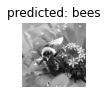

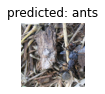

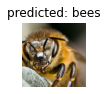

In [17]:
visualize_model(model_conv)

plt.ioff()
plt.show()

### Using Resnet18, train model for 20 epochs - With pretrained weights, unfreeze some extra layers in extractor

In [18]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [19]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=21)

Epoch 0/20
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7104 Acc: 0.6311
val Loss: 0.3573 Acc: 0.8693

Epoch 1/20
----------
train Loss: 0.3968 Acc: 0.8443
val Loss: 0.3619 Acc: 0.8954

Epoch 2/20
----------
train Loss: 0.6222 Acc: 0.7951
val Loss: 0.7195 Acc: 0.7386

Epoch 3/20
----------
train Loss: 0.4838 Acc: 0.7992
val Loss: 0.2806 Acc: 0.8627

Epoch 4/20
----------
train Loss: 0.5145 Acc: 0.8197
val Loss: 0.3947 Acc: 0.8693

Epoch 5/20
----------
train Loss: 0.5543 Acc: 0.7910
val Loss: 0.2937 Acc: 0.8497

Epoch 6/20
----------
train Loss: 0.4400 Acc: 0.8238
val Loss: 0.4039 Acc: 0.8235

Epoch 7/20
----------
train Loss: 0.2565 Acc: 0.8852
val Loss: 0.2213 Acc: 0.9020

Epoch 8/20
----------
train Loss: 0.2975 Acc: 0.8648
val Loss: 0.2033 Acc: 0.9216

Epoch 9/20
----------
train Loss: 0.3581 Acc: 0.8443
val Loss: 0.2120 Acc: 0.9150

Epoch 10/20
----------
train Loss: 0.3681 Acc: 0.8402
val Loss: 0.2022 Acc: 0.9150

Epoch 11/20
----------
train Loss: 0.2473 Acc: 0.9221
val Loss: 0.1896 Acc: 0.9085

Epoch 12/20
----------
t

### Using Resnet18, train model for 20 epochs - With pretrained weights, unfreeze all extractor layers

In [20]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [21]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=21)

Epoch 0/20
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5860 Acc: 0.6721
val Loss: 0.2720 Acc: 0.8824

Epoch 1/20
----------
train Loss: 0.6777 Acc: 0.7049
val Loss: 0.2106 Acc: 0.9281

Epoch 2/20
----------
train Loss: 0.4978 Acc: 0.7910
val Loss: 0.1841 Acc: 0.9542

Epoch 3/20
----------
train Loss: 0.4347 Acc: 0.8156
val Loss: 0.1944 Acc: 0.9477

Epoch 4/20
----------
train Loss: 0.6180 Acc: 0.7500
val Loss: 0.1952 Acc: 0.9412

Epoch 5/20
----------
train Loss: 0.2799 Acc: 0.8893
val Loss: 0.2139 Acc: 0.9281

Epoch 6/20
----------
train Loss: 0.5003 Acc: 0.8074
val Loss: 0.2734 Acc: 0.9085

Epoch 7/20
----------
train Loss: 0.3834 Acc: 0.8402
val Loss: 0.1761 Acc: 0.9412

Epoch 8/20
----------
train Loss: 0.4031 Acc: 0.7992
val Loss: 0.1955 Acc: 0.9412

Epoch 9/20
----------
train Loss: 0.2891 Acc: 0.8730
val Loss: 0.1588 Acc: 0.9477

Epoch 10/20
----------
train Loss: 0.3448 Acc: 0.8484
val Loss: 0.1982 Acc: 0.9346

Epoch 11/20
----------
train Loss: 0.3903 Acc: 0.8402
val Loss: 0.1821 Acc: 0.9542

Epoch 12/20
----------
t

### Discussion/Findings
* Without pretrained weights:Training completed in **26m 5s** and Best val Acc: **0.692810** (began with accuracy of 62.09%)

* With pretrained weights, freezing extractor part: Training completed in **11m 57s** and Best val Acc: **0.960784** (began with accuracy of 73.2%)

* With pretrained weights, unfreeze some extra layers in extractor:Training completed in **26m 1s** and Best val Acc: **0.934641** (began with acc of 89.54%)

* With pretrained weights, unfreeze all extractor layers:Training completed in 25m 26s
Best val Acc: 0.960784 (began with acc of 92.81%)

With Tranfer Learning time spent on modeling could be reduced drastically. Often the accuracy of first epoch is much higher when using pretrained weights. There are ways to improve/finetune the accuracy of modeling. 
